# Dependencies

Those of you new to jupyter notebooks:
Either click the >| Run button or Shift+Enter to step through each cell, or the >> button to restart and run all cells

In [1]:
from sklearn.datasets import load_iris
from IPython.display import display, clear_output
from sklearn import model_selection
import numpy as np

# In order to ignore FutureWarning from TensorFlow
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from keras.models import Sequential
from keras.layers import Dense

import matplotlib.pyplot as plt
%matplotlib inline


# includes a class PlotCallback that helps plot our neural network training output
import plot_helper

Using TensorFlow backend.


### Reproducible results

Sometimes when doing machine learning, you want to be able to have reproducible results.
Most of the algorithms used have some kind of random aspect to them that make them work and make them effective.
For teaching and development purposes, this can sometimes get in the way, so I've decided to lock the random state so you can have a steady environment to work in.

**Don't do this for production models!**
We're breaking some useful features and also limiting ourselves to a single thread. It doesn't matter for this example, but for other models it will.

(Don't worry about the code, it's not really interesting, but there sure is a lot of it)

In [2]:
# Docs: https://keras.io/getting-started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development
import tensorflow as tf
import keras.backend as K
import random as rn

random_state = 42
np.random.seed(random_state)
tf.set_random_seed(random_state)
rn.seed(random_state)

session_conf = tf.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

# Load the Iris dataset from sklearn

In [3]:
iris=load_iris()

## Extract the data, target classes and features from the iris dataset

In [4]:
data, feature_names = iris.data, iris.feature_names
target, target_names = iris.target, iris.target_names

# The Iris dataset

The [iris dataset](https://en.wikipedia.org/wiki/Iris_flower_data_set) consists of 150 samples equally distributed over three classes of the iris flower, namely 'Iris Setosa', 'Iris Versicolor' and 'Iris Virginica'.

The samples consist of four continunous features measured on real-world samples, as listed below:
1. Sepal Length (cm)
2. Sepal Width (cm)
3. Petal Length (cm)
4. Petal Width (cm)

For the non-botanically inclined - The petals are each individual leaf on the flower when in bloom. The sepals of the flower are the green leafy things by the foot of the flower near the stem protecting the flower petals.

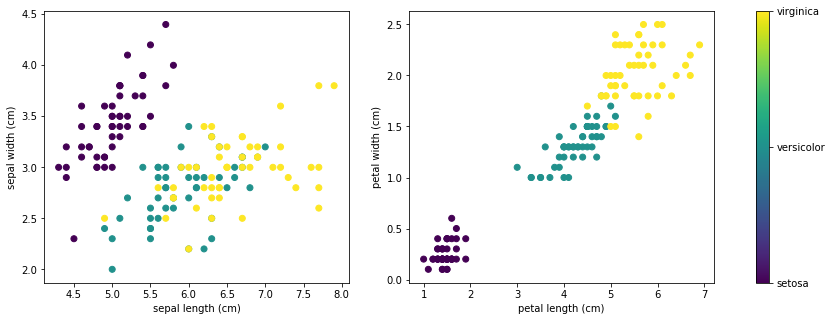

In [5]:
# Plotting code for the scatter plots
features = [(0, 1), (2, 3)] # Sepals and petals

# create a subplot with 1 row and as many columns as we have comparisons
fig, axes = plt.subplots(nrows=1, ncols=len(features), figsize=(15,5))

for i, feature in enumerate(features):
    x, y = feature

    # Create a scatter plot in the i-th subplot
    scatter = axes[i].scatter(data[:, x], data[:, y], c=target)
    axes[i].set(xlabel=feature_names[x], ylabel=feature_names[y])


# A function to translate the target indices to string names for the color bar
formatter = plt.FuncFormatter(lambda s, *args: target_names[s])
fig.colorbar(scatter, ax=axes, ticks=[0, 1, 2], format=formatter)

plt.show()

Above is a quick scatterplot over the features so we can see how the data points are distributed amongst each other.

## Split the dataset into a holdout and training set

We could do this manually, but here we're using sklearn to automatically split our data matrix and target vector for us in a sensible way.

Tweaking these values can have a big impact on the efficiency of the network and how well it learns.

In [6]:
# Determines the size of the test data set
test_size = 0.4 # 0.5 is 50%

# Shuffling the data can help against a biased training set
shuffle_dataset = True

# Will ensure there's a (roughly) equal ratio of the classes in the training and test split.
stratify_dataset = None # Can only be set to "target" if shuffle is True, otherwise None
#stratify_dataset = target

X_train, X_test, y_train, y_test = model_selection.train_test_split(data, target, test_size=test_size, random_state=random_state, shuffle=shuffle_dataset, stratify=stratify_dataset)

print("Training data classes: \n", y_train)
print("Test data classes: \n", y_test)

Training data classes: 
 [2 0 0 0 1 0 1 2 0 1 2 0 2 2 1 1 2 1 0 1 2 0 0 1 1 0 2 0 0 1 1 2 1 2 2 1 0
 0 2 2 0 0 0 1 2 0 2 2 0 1 1 2 1 2 0 2 1 2 1 1 1 0 1 1 0 1 2 2 0 1 2 2 0 2
 0 1 2 2 1 2 1 1 2 2 0 1 2 0 1 2]
Test data classes: 
 [1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0 0 0 2 1 1 0 0 1 2 2 1 2 1 2 1 0 2 1 0 0 0 1]


## Construct a simple neural network with Keras

And print the network structure

We start by initializing a sequential Keras model, which is one of Keras' many ways of building models.
Layers are added to this by calling `model.add(<layer>)` in sequence, and the model is finalized by calling `model.compile`.

We then define the layers of the network.
- Dense: creates a fully connected (dense) layer of neurons.
- input_dim: specifies the amount of input neurons. If you don't specify it will use the output of the previous layer.
- activation: The activation function to use. We haven't covered activation functions much, but they help the network achieve more than just linear solutions to problems. They have different features and affect both the learning speed and result in remarkable ways. They are mostly required for more complex problems.

An example of the most minimal network you could make, would be (without nonlinearities): 

`Dense(output_features, input_dim=input_features, activation='softmax')`

There's a lot of resources on this if you search online.

Because this is a very simple dataset to solve with neural networks, we can ignore some conventional wisdom we also haven't covered much in this course, such as one-hot encoding the output classes, normalizing the inputs and using regularization mechanisms in the network. Don't worry much about these things for now - but know that there's a much more to neural networks than this!

### Hyperparameters

The hyperparameters we'll be working with in this example are fairly simple, and limited to the size of the layers.

You can also try playing with the activation function, but `relu` has taken the throne as the most widely used over `sigmoid`, as it is more well-behaved and usually results in faster and more reliable learning.

ReLU: or Rectified Linear Unit, is an activation function that returns 0 when values are negative

Sigmoid: is a function that squishes a value between 0 and 1


You'll also notice the output layer has an activation function called `softmax`. This is a commonly used activation for classification problems with multiple classes. It takes an input space and returns a normalized list of probabilities instead that sums to 1. You thus get a probability for each class that you can convert into a result as to what the network thinks it is.

In [7]:
first_layer_neurons = 3
hidden_layer_neurons = 3

activation_function = 'relu' # 'relu' and 'sigmoid' are two good options.

In [8]:
input_features = len(feature_names)
output_features = 3

# Initialize a sequential keras model
model = Sequential(name="Iris Classifier")

# Define the layers of the network
input_layer = Dense(first_layer_neurons, input_dim=input_features, activation=activation_function)
hidden_layer = Dense(hidden_layer_neurons, activation=activation_function)
output_layer = Dense(output_features, activation='softmax')

# Add the layers to the sequential model. For the exercises, you can try to add and remove layers here. 
model.add(input_layer)
model.add(hidden_layer)
model.add(output_layer)

# Bake the model with a loss function and optimizer. You shouldn't have to change this for the exercises
model.compile(
    # the loss function determines how far "off" the model is when comparing results
    loss='sparse_categorical_crossentropy',
    # The optimizer is in charge of stepping and updating the weights according to the gradient step in learning
    # Don't worry about it too much in this example.
    optimizer='SGD',
    metrics=['accuracy']
)

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 3)                 15        
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 12        
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 12        
Total params: 39
Trainable params: 39
Non-trainable params: 0
_________________________________________________________________


## Training the neural network

Epoch 50 out of 50
Test loss: 1.10
Test accuracy: 35.71%


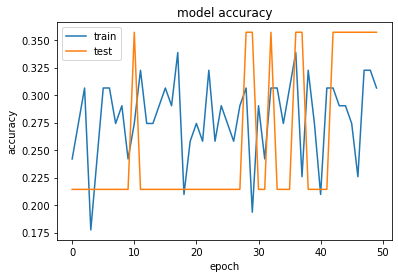

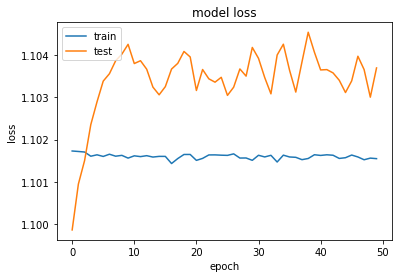

In [9]:
# The amount of iterations to train for
max_epochs=50

# This parameter further splits out 30% of the data for validation during training
validation_split = 0.3

plot_callback = plot_helper.PlotCallback(max_epochs)
fitted_model = model.fit(X_train, y_train,
                         batch_size=1,
                         epochs=max_epochs,
                         verbose=0,
                         validation_split=validation_split,
                         callbacks=[plot_callback])    

We need to do a bit more work to get the estimates out of the network.
Softmax returns probabilities for each class, so we need to convert them to a definitive answer to plot the confusion matrix

One way to do this is to use the np.argmax function on each row (from the numpy package).
Argmax returns the INDEX of the element with the highest value in an array. As our result is an array of arrays, this is a way to select the element with the highest probability.


In [10]:
# Get results from model
y_est_test = model.predict(X_test)

# Get the highest probability class for each of the answers
y_est_test = np.argmax(y_est_test, axis=1)
y_est_test

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

## Calculate the Accuracy of the holdout set

In [11]:
generalization_error = np.sum(y_est_test != y_test) / len(y_test)
print("Accuracy of the classifier on the test set: {:.2f}%".format(100 * (1 - generalization_error)))

Accuracy of the classifier on the test set: 31.67%


# Plot a confusion matrix

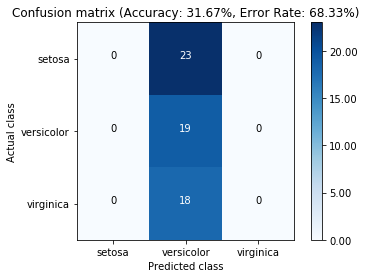

In [12]:
from sklearn.metrics import confusion_matrix

# Build a confusion matrix from the test set and the model results
cm = confusion_matrix(y_test, y_est_test, labels=range(len(target_names)))

plot_helper.plot_confusion_matrix(cm, target_names) # This is the same function as in the decision tree example


# Exercise

The Iris dataset is quite trivial to solve with a neural network to a high accuracy (95-98%). I've tried to compose a network that doesn't quite achieve this (but it may vary on your machine due to randomness!).

1. Run the code and read through it to get a feel for what it does
    1. Reflect: Take a look at the training graphs. Try to think on what it's telling you. Typically, we'd want to see a "hockey stick" graph, where it initially learns quite fast, and then slowly converges to a solution. We want to avoid it maxing out at or close to 100% too fast, as it is then likely to overfit to the training data rather than learning something generally useful. Similarly, if it doesn't seem to improve after a few epochs, it is likely not a good network.
        1. Is the network learning?
        1. Is the network overfitting?
        1. Is the network strong enough, or too strong?
    1. Take a look at the hyper parameters. Try to tweak the network size and amount of layers until you get a good solution.
1. Play with the hyper parameters and try to improve your test score.
    - Remember to take notes of your configurations and their results.
    - Reflect on the results.
    
What is the best test accuracy you're able to get?

# Hints

1. Hints for exercise 1
    1. This is a VERY simple problem for neural networks to solve, so a number of things might be wrong.
        1. It might be too strong. Try reducing the neurons or removing entirely the hidden layer and seeing what it does.
        1. It might be too complex. Try setting the activation function to None.
        1. It might have too little data to learn from - try adjusting the validation split in the model.fit call, and/or the test_split to give it more data.
        1. Try adding stratification to the dataset.
        1. You can try training for more epochs.
        
The lesson I've tried to set up is that bigger and more complex networks aren't always better. You need to look at the data and consider the size and complexity of it, and what might solve it. It often pays off to start small and scale up as required, rather than start with a large model and trim it down.